In [1]:
import os
import numpy as np
import time
import random
import csv

import torch
torch.manual_seed(17)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader, Subset, random_split
# from transformers import ConvNextForImageClassification нужен ли?
from torchvision.transforms.functional import to_pil_image
from torchvision import models,transforms

from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

from utils import root, label_map, tensor_to_img, imgs_df, multiply_factor, itm_list, get_sampler_weight, get_class_weights,\
iou_dice_score, mask_circuit, iou_dice_score, show_masks

from model import initialize_segment_model, device
from train import segmentation_train, segmentation_eval
from dataset import MNISTHAM10000

## Dataset

In [25]:
# разделяем данные пополам и берем только одну половину для обучения моделей
data_train, data_test = train_test_split(imgs_df[['image_id','dx', 'cell_type_idx']], test_size=0.4)

In [26]:
len(data_train), len(data_train)

(6009, 6009)

In [27]:
img_transform = transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
        ])

mask_transform = transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
        ])

In [34]:
exm_dataset = MNISTHAM10000(root, data_train, True, multiply_factor(data_train), itm_list, img_transform, mask_transform)
train_dataset, val_dataset, test_dataset = random_split(exm_dataset, [0.8, 0.07, 0.13])

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True)

val_loader = DataLoader(
    val_dataset, batch_size=16, shuffle=True)

test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=False)

In [89]:
# преместить в utils
def show_masks(images, masks, predicted_masks):
    '''
    функция для визуального сравнения исходных масок и предсказанных моделью
    вход: 
    вывод: исходное изображение, исходная маска, предсказанная маска
    '''
    assert len(images) == len(masks) == len(predicted_masks)
    if len(images) in [1, 2]:
        fig, axes = plt.subplots(1, 5, figsize=(15,15))
        axes[0].imshow(tensor_to_img(images[0], True))
        axes[0].set_xlabel('original img')
        axes[1].imshow(tensor_to_img(masks[0], True))
        axes[1].set_xlabel('original mask')
        axes[2].imshow(mask_circuit(images[0], masks[0], True, False))
        axes[2].set_xlabel('original mask+img')
        axes[3].imshow(tensor_to_img(predicted_masks[0], True))
        axes[3].set_xlabel('predicted mask')
        axes[4].imshow(mask_circuit(images[0], predicted_masks[0], True, False))
        axes[4].set_xlabel('predicted mask+img')
    else:
        n = np.random.randint(2, (len(images) if len(images) <= 5 else 5))
        fig, axes = plt.subplots(len(images[:n]), 5, figsize=(15,15))
        for i in range(len(images[:n])):
            axes[i, 0].imshow(tensor_to_img(images[i], True))
            axes[i, 0].set_xlabel('original img')
            axes[i, 1].imshow(tensor_to_img(masks[i], True))
            axes[i, 1].set_xlabel('original mask')
            axes[i, 2].imshow(mask_circuit(images[i], masks[i], True, False))
            axes[i, 2].set_xlabel('original mask+img')
            axes[i, 3].imshow(tensor_to_img(predicted_masks[i], True))
            axes[i, 3].set_xlabel('predicted mask')
            axes[i, 4].imshow(mask_circuit(images[i], predicted_masks[i], True, False))
            axes[i, 4].set_xlabel('predicted mask+img')

## deeplabv3

[epoch 1], [iter 50/1506], [train loss 0.444],[train IoU acc 0.478], [train Dice acc 0.640]
[epoch 1], [iter 100/1506], [train loss 0.382],[train IoU acc 0.556], [train Dice acc 0.707]
[epoch 1], [iter 150/1506], [train loss 0.354],[train IoU acc 0.591], [train Dice acc 0.735]
[epoch 1], [iter 200/1506], [train loss 0.338],[train IoU acc 0.608], [train Dice acc 0.749]
[epoch 1], [iter 250/1506], [train loss 0.327],[train IoU acc 0.620], [train Dice acc 0.759]
[epoch 1], [iter 300/1506], [train loss 0.326],[train IoU acc 0.622], [train Dice acc 0.761]
[epoch 1], [iter 350/1506], [train loss 0.314],[train IoU acc 0.634], [train Dice acc 0.770]
[epoch 1], [iter 400/1506], [train loss 0.312],[train IoU acc 0.638], [train Dice acc 0.773]
[epoch 1], [iter 450/1506], [train loss 0.309],[train IoU acc 0.643], [train Dice acc 0.777]
[epoch 1], [iter 500/1506], [train loss 0.305],[train IoU acc 0.650], [train Dice acc 0.782]
[epoch 1], [iter 550/1506], [train loss 0.301],[train IoU acc 0.655], [

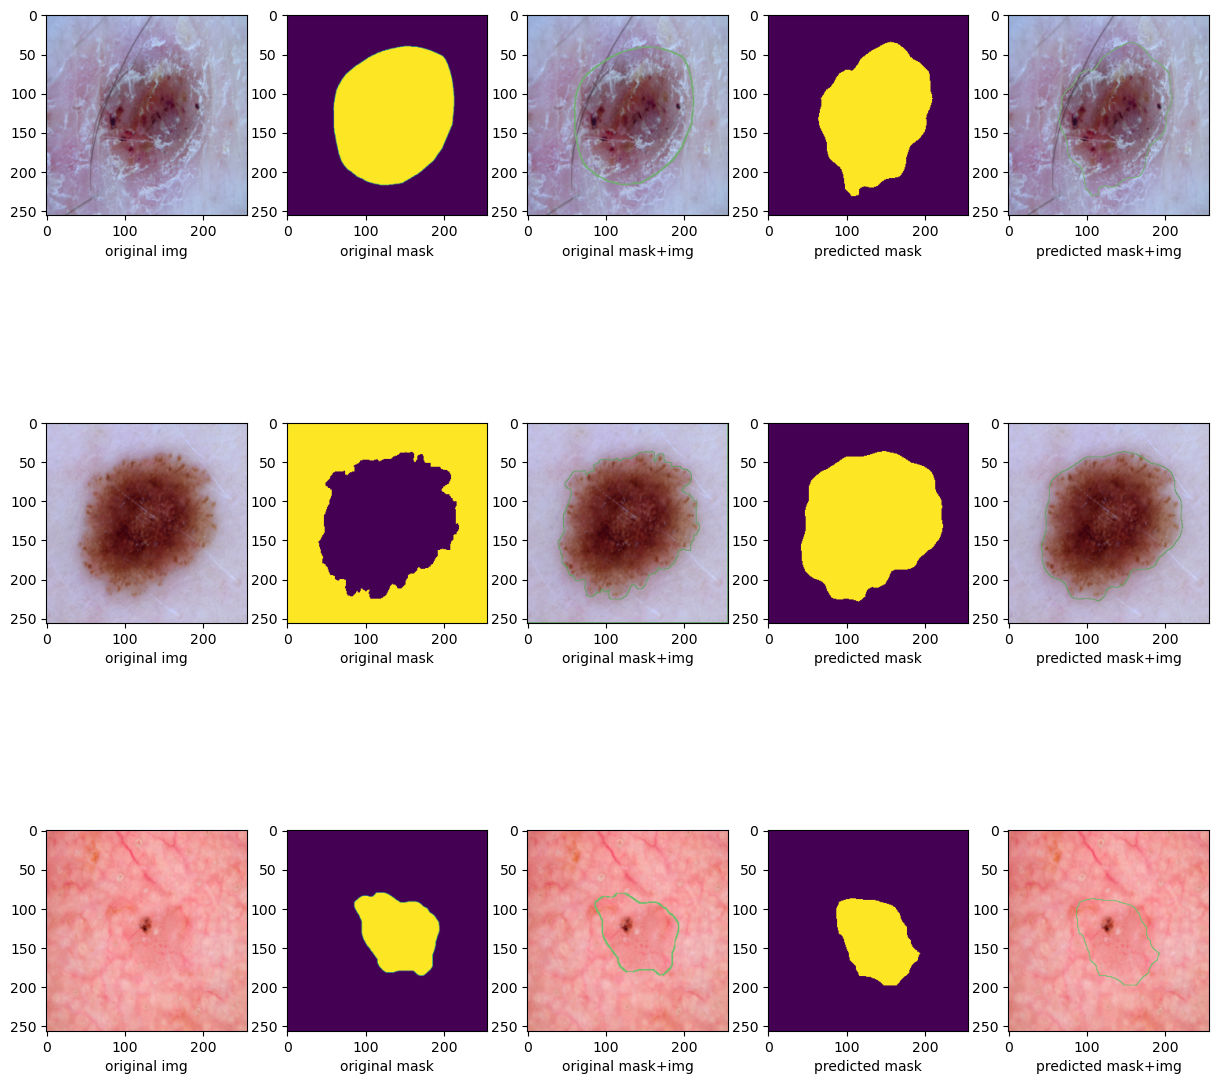

In [38]:
file = open("deeplabv3_training_logs.csv", mode="w", newline="")
writer = csv.writer(file)
writer.writerow(["Epoch", "Train Loss", "Train IoU Accuracy", "Train Dice Accuracy", "Val Loss", "Val IoU Accuracy", "Val Dice Accuracy"])

model_dlv3_pyt = initialize_segment_model('DeepLabV3')

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model_dlv3_pyt.parameters(), lr=0.001, weight_decay=1e-5)

total_loss_train = []
total_iou_train = []
total_dice_train = []

total_loss_val = []
total_iou_val = []
total_dice_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, iou_train, dice_train = segmentation_train(train_loader, model_dlv3_pyt, criterion, optimizer, epoch, 0.5, 50)
    
    total_loss_train += loss_train
    total_iou_train += iou_train
    total_dice_train += dice_train
    
    loss_val, iou_val, dice_val = segmentation_eval(val_loader, model_dlv3_pyt, criterion, optimizer, 0.5, validation=True, epoch=epoch)

    total_loss_val += loss_val
    total_iou_val += iou_val
    total_dice_val += dice_val

    writer.writerow([epoch, loss_train, iou_train, dice_train, loss_val, iou_val, dice_val])
    print('*****************************************************')
    
file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

total_loss_test, total_iou_test, total_dice_test = segmentation_eval(test_loader, model_dlv3_pyt, criterion, optimizer, 0.5, show=True, validation=False, epoch=None)

save_path = "model_deeplabv3.pth"
# # # Save the trained model
# torch.save(model_dlv3_pyt.state_dict(), save_path)
torch.save(model_dlv3_pyt, save_path)

------------------------------------------------------------
Test: [loss 0.175], [IoU 0.791], [Dice 0.882]
------------------------------------------------------------


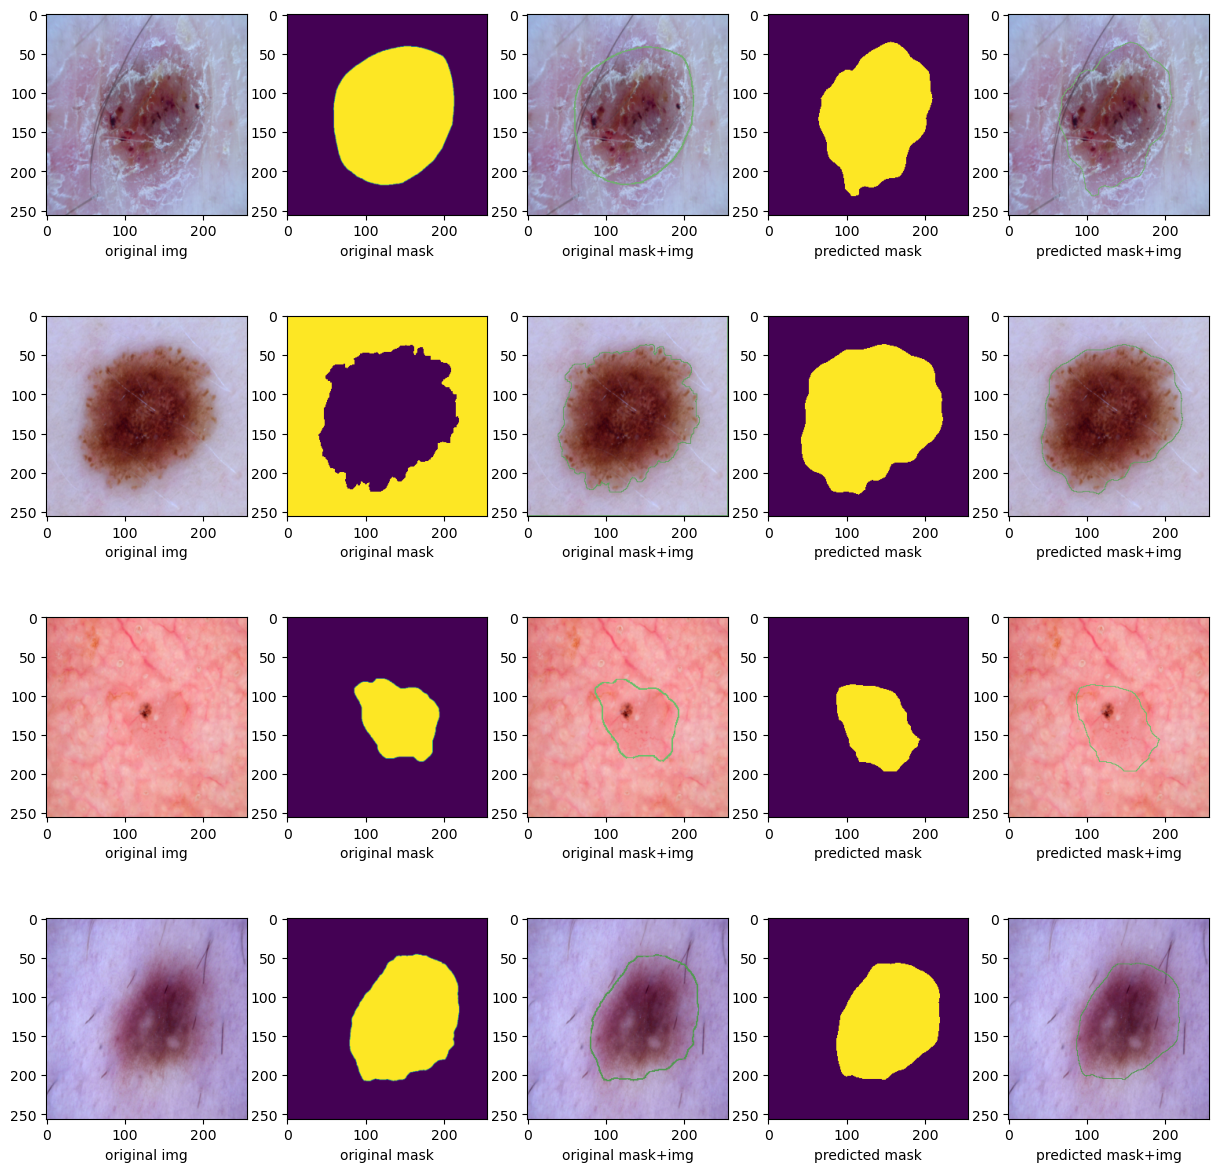

In [47]:
# train_dataset_2, val_dataset_2, test_dataset_2 = random_split(exm_dataset, [0.75, 0.05, 0.2])

# test_loader_2 = DataLoader(
#     test_dataset_2, batch_size=16, shuffle=False)

total_loss_test, total_iou_test, total_dice_test = segmentation_eval(test_loader, model_dlv3_pyt, criterion, optimizer, 0.5, show=True, validation=False, epoch=None)

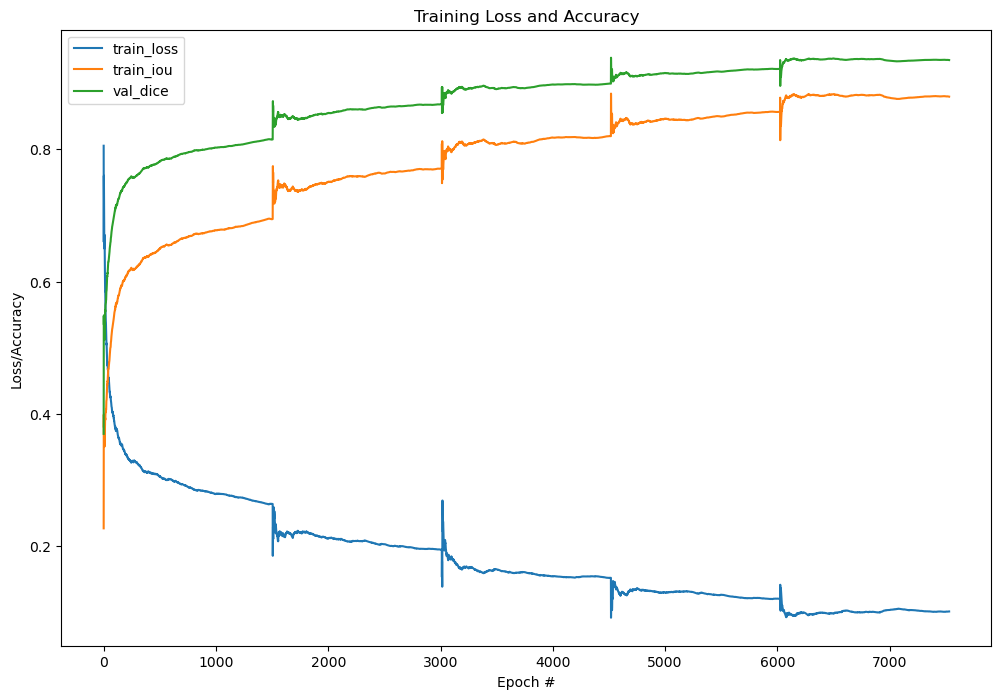

In [40]:
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_iou_train, label="train_iou")
plt.plot(total_dice_train, label="val_dice")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

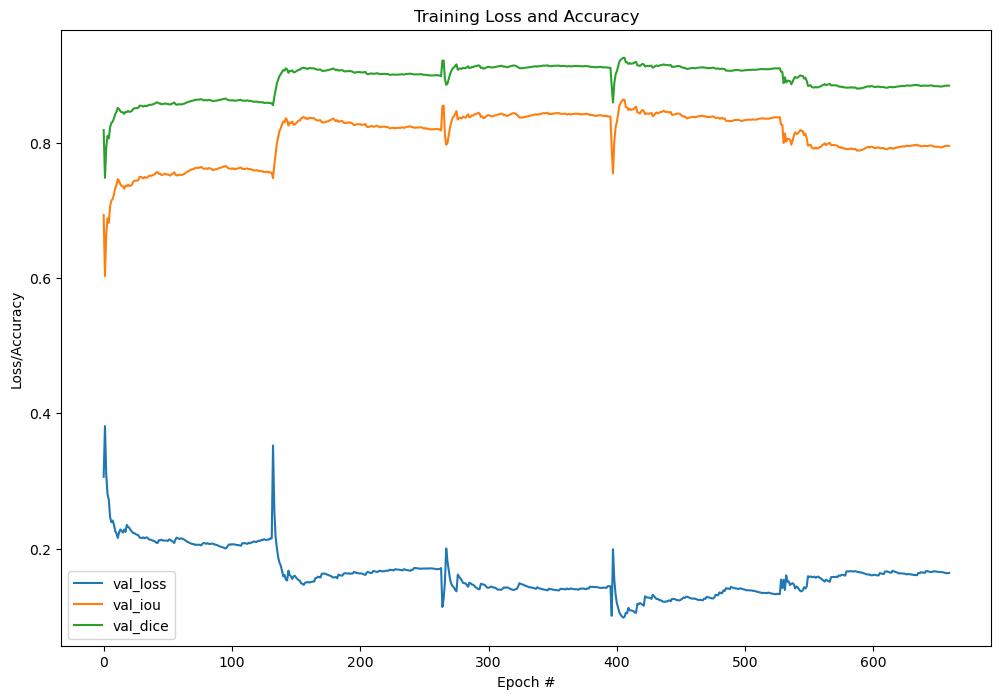

In [41]:
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_iou_val, label="val_iou")
plt.plot(total_dice_val, label="val_dice")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Unet

[epoch 1], [iter 50/1506], [train loss 0.483],[train IoU acc 0.507], [train Dice acc 0.667]
[epoch 1], [iter 100/1506], [train loss 0.411],[train IoU acc 0.561], [train Dice acc 0.713]
[epoch 1], [iter 150/1506], [train loss 0.386],[train IoU acc 0.581], [train Dice acc 0.729]
[epoch 1], [iter 200/1506], [train loss 0.365],[train IoU acc 0.597], [train Dice acc 0.741]
[epoch 1], [iter 250/1506], [train loss 0.352],[train IoU acc 0.608], [train Dice acc 0.751]
[epoch 1], [iter 300/1506], [train loss 0.340],[train IoU acc 0.619], [train Dice acc 0.759]
[epoch 1], [iter 350/1506], [train loss 0.333],[train IoU acc 0.627], [train Dice acc 0.765]
[epoch 1], [iter 400/1506], [train loss 0.328],[train IoU acc 0.631], [train Dice acc 0.768]
[epoch 1], [iter 450/1506], [train loss 0.325],[train IoU acc 0.635], [train Dice acc 0.771]
[epoch 1], [iter 500/1506], [train loss 0.322],[train IoU acc 0.639], [train Dice acc 0.774]
[epoch 1], [iter 550/1506], [train loss 0.318],[train IoU acc 0.643], [

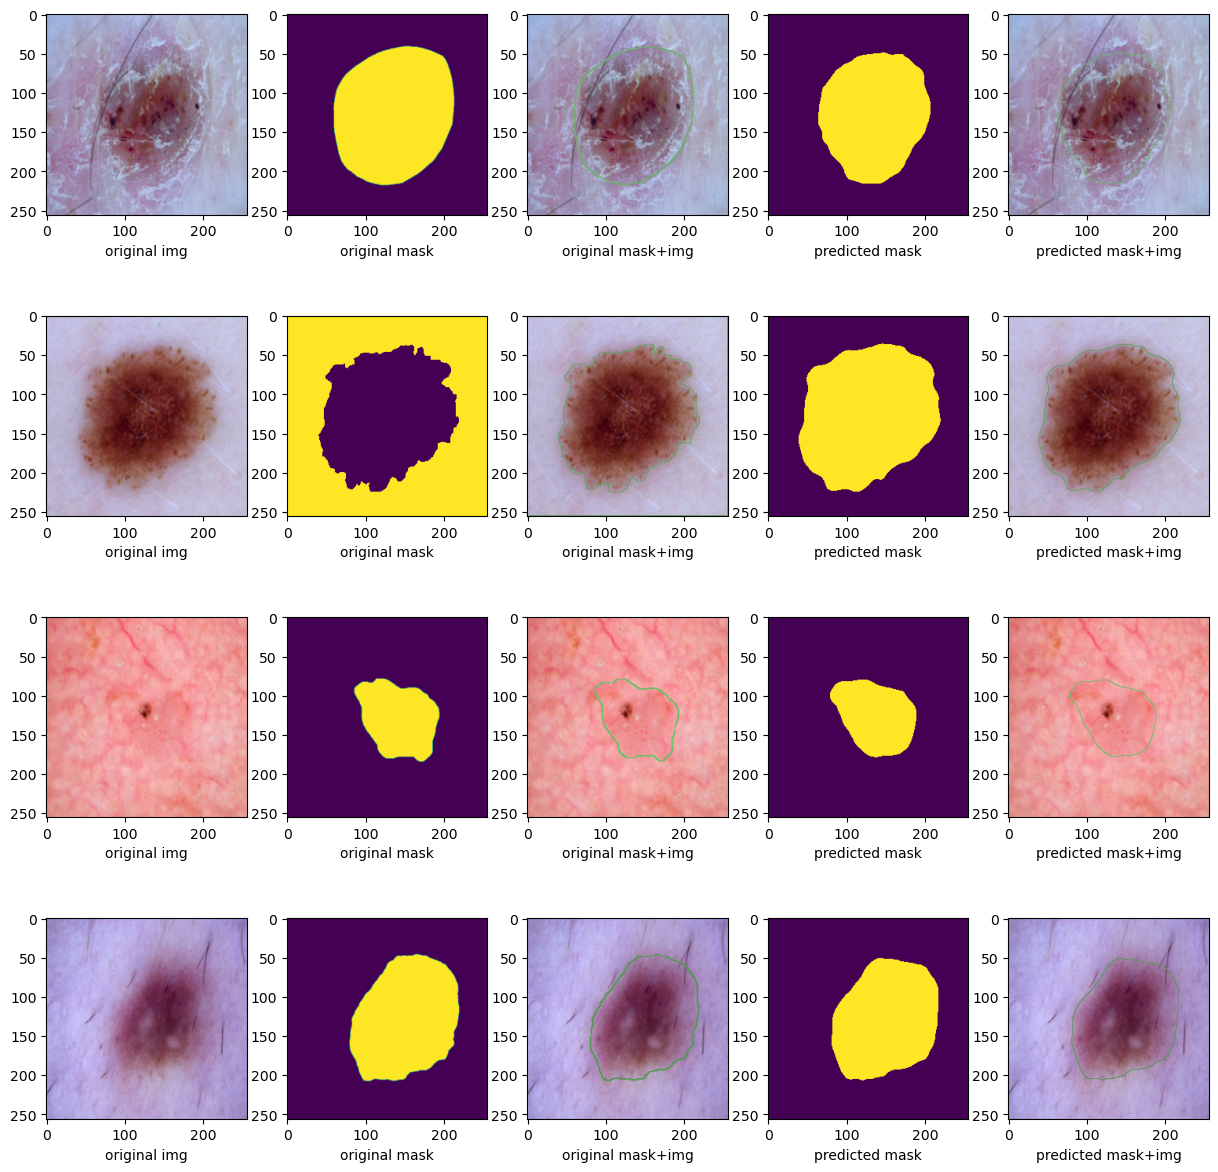

In [42]:
file = open("Unet_training_logs.csv", mode="w", newline="")
writer = csv.writer(file)
writer.writerow(["Epoch", "Train Loss", "Train IoU Accuracy", "Train Dice Accuracy", "Val Loss", "Val IoU Accuracy", "Val Dice Accuracy"])

model_unet_pyt = initialize_segment_model('Unet')

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model_unet_pyt.parameters(), lr=0.001, weight_decay=1e-5)

total_loss_train = []
total_iou_train = []
total_dice_train = []

total_loss_val = []
total_iou_val = []
total_dice_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, iou_train, dice_train = segmentation_train(train_loader, model_unet_pyt, criterion, optimizer, epoch, 0.5, 50)
    
    total_loss_train += loss_train
    total_iou_train += iou_train
    total_dice_train += dice_train
    
    loss_val, iou_val, dice_val = segmentation_eval(val_loader, model_unet_pyt, criterion, optimizer, 0.5, validation=True, epoch=epoch)

    total_loss_val += loss_val
    total_iou_val += iou_val
    total_dice_val += dice_val

    writer.writerow([epoch, loss_train, iou_train, dice_train, loss_val, iou_val, dice_val])
    print('*****************************************************')
    
file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

# total_loss_test, total_iou_test, total_dice_test = segmentation_eval(test_loader, model_unet_pyt, criterion, optimizer, 0.5, show=True, validation=False, epoch=None)

save_path = "model_Unet.pth"
# # # Save the trained model
# torch.save(model_unet_pyt.state_dict(), save_path)
torch.save(model_unet_pyt, save_path)

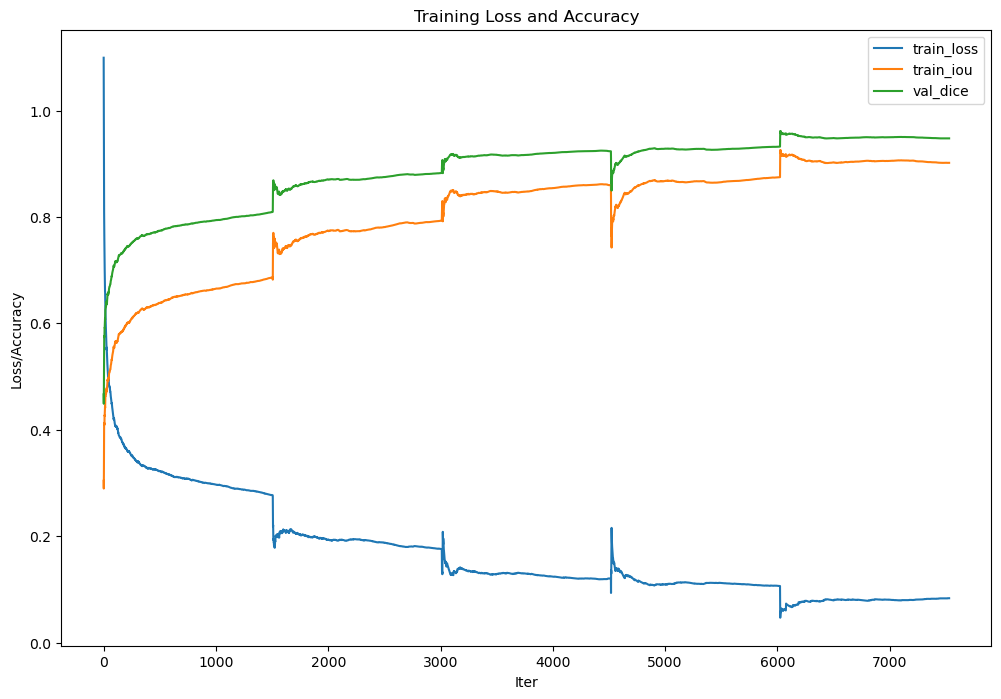

In [43]:
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_iou_train, label="train_iou")
plt.plot(total_dice_train, label="val_dice")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iter")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

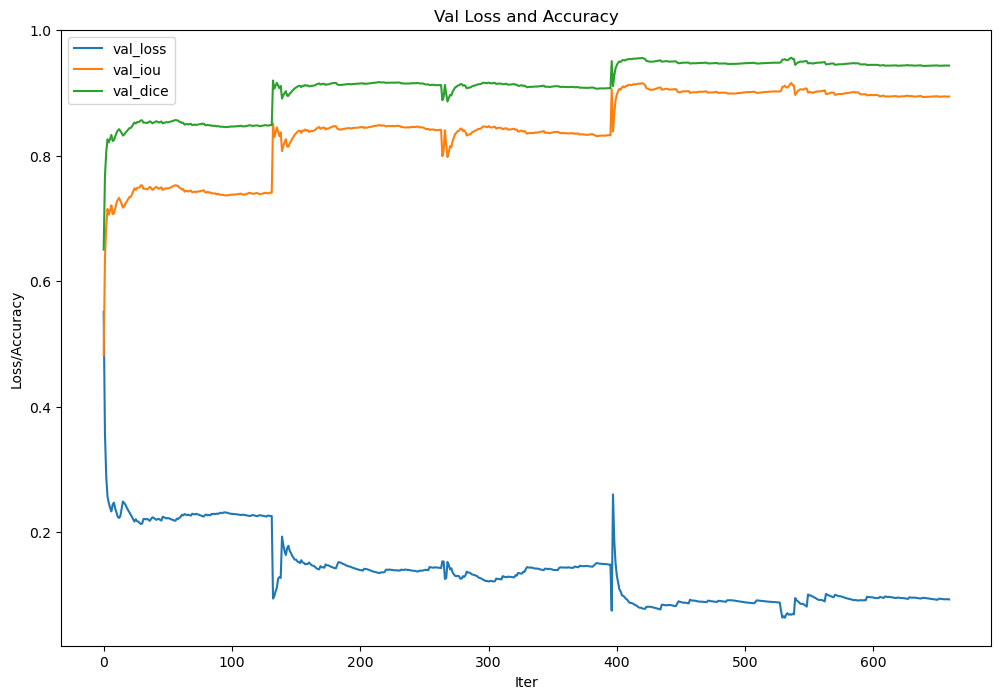

In [44]:
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_iou_val, label="val_iou")
plt.plot(total_dice_val, label="val_dice")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iter")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Обучение лучшей модели на полном наборе данных

[epoch 1], [iter 100/1882], [train loss 0.368],[train IoU acc 0.572], [train Dice acc 0.719]
[epoch 1], [iter 200/1882], [train loss 0.347],[train IoU acc 0.602], [train Dice acc 0.745]
[epoch 1], [iter 300/1882], [train loss 0.334],[train IoU acc 0.620], [train Dice acc 0.759]
[epoch 1], [iter 400/1882], [train loss 0.327],[train IoU acc 0.630], [train Dice acc 0.767]
[epoch 1], [iter 500/1882], [train loss 0.319],[train IoU acc 0.641], [train Dice acc 0.775]
[epoch 1], [iter 600/1882], [train loss 0.311],[train IoU acc 0.648], [train Dice acc 0.781]
[epoch 1], [iter 700/1882], [train loss 0.307],[train IoU acc 0.652], [train Dice acc 0.783]
[epoch 1], [iter 800/1882], [train loss 0.300],[train IoU acc 0.659], [train Dice acc 0.789]
[epoch 1], [iter 900/1882], [train loss 0.295],[train IoU acc 0.664], [train Dice acc 0.793]
[epoch 1], [iter 1000/1882], [train loss 0.293],[train IoU acc 0.666], [train Dice acc 0.795]
[epoch 1], [iter 1100/1882], [train loss 0.291],[train IoU acc 0.670]

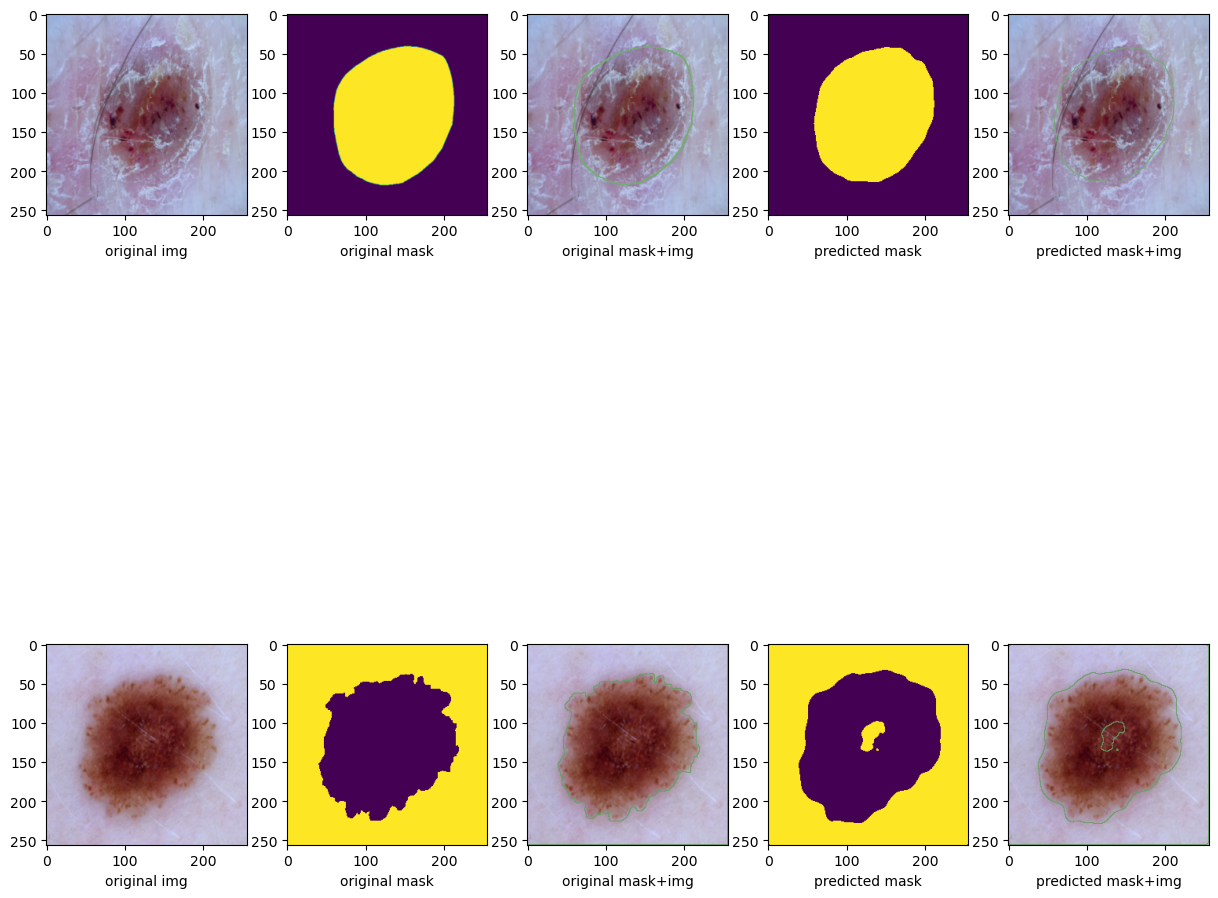

In [48]:
train_loader = DataLoader(
    exm_dataset, batch_size=16, shuffle=True)

file = open("full_Unet_training_logs.csv", mode="w", newline="")
writer = csv.writer(file)
writer.writerow(["Epoch", "Train Loss", "Train IoU Accuracy", "Train Dice Accuracy", "Val Loss", "Val IoU Accuracy", "Val Dice Accuracy"])

full_model_unet = initialize_segment_model('Unet')

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(full_model_unet.parameters(), lr=0.001, weight_decay=1e-5)

total_loss_train = []
total_iou_train = []
total_dice_train = []

total_loss_val = []
total_iou_val = []
total_dice_val = []

start_time = time.time()

epoch_num = 10
for epoch in range(1, epoch_num+1):

    loss_train, iou_train, dice_train = segmentation_train(train_loader, full_model_unet, criterion, optimizer, epoch, 0.5, 100)
    
    total_loss_train += loss_train
    total_iou_train += iou_train
    total_dice_train += dice_train
    
    loss_val, iou_val, dice_val = segmentation_eval(val_loader, full_model_unet, criterion, optimizer, 0.5, validation=True, epoch=epoch)

    total_loss_val += loss_val
    total_iou_val += iou_val
    total_dice_val += dice_val

    writer.writerow([epoch, loss_train, iou_train, dice_train, loss_val, iou_val, dice_val])
    print('*****************************************************')
    
file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

# total_loss_test, total_iou_test, total_dice_test = segmentation_eval(test_loader, full_model_unet, criterion, optimizer, 0.5, show=True, validation=False, epoch=None)

save_path = "full_unet.pth"
# # # Save the trained model
# torch.save(model_dlv3_pyt.state_dict(), save_path)
torch.save(full_model_unet, save_path)

------------------------------------------------------------
Test: [loss 0.035], [IoU 0.951], [Dice 0.975]
------------------------------------------------------------


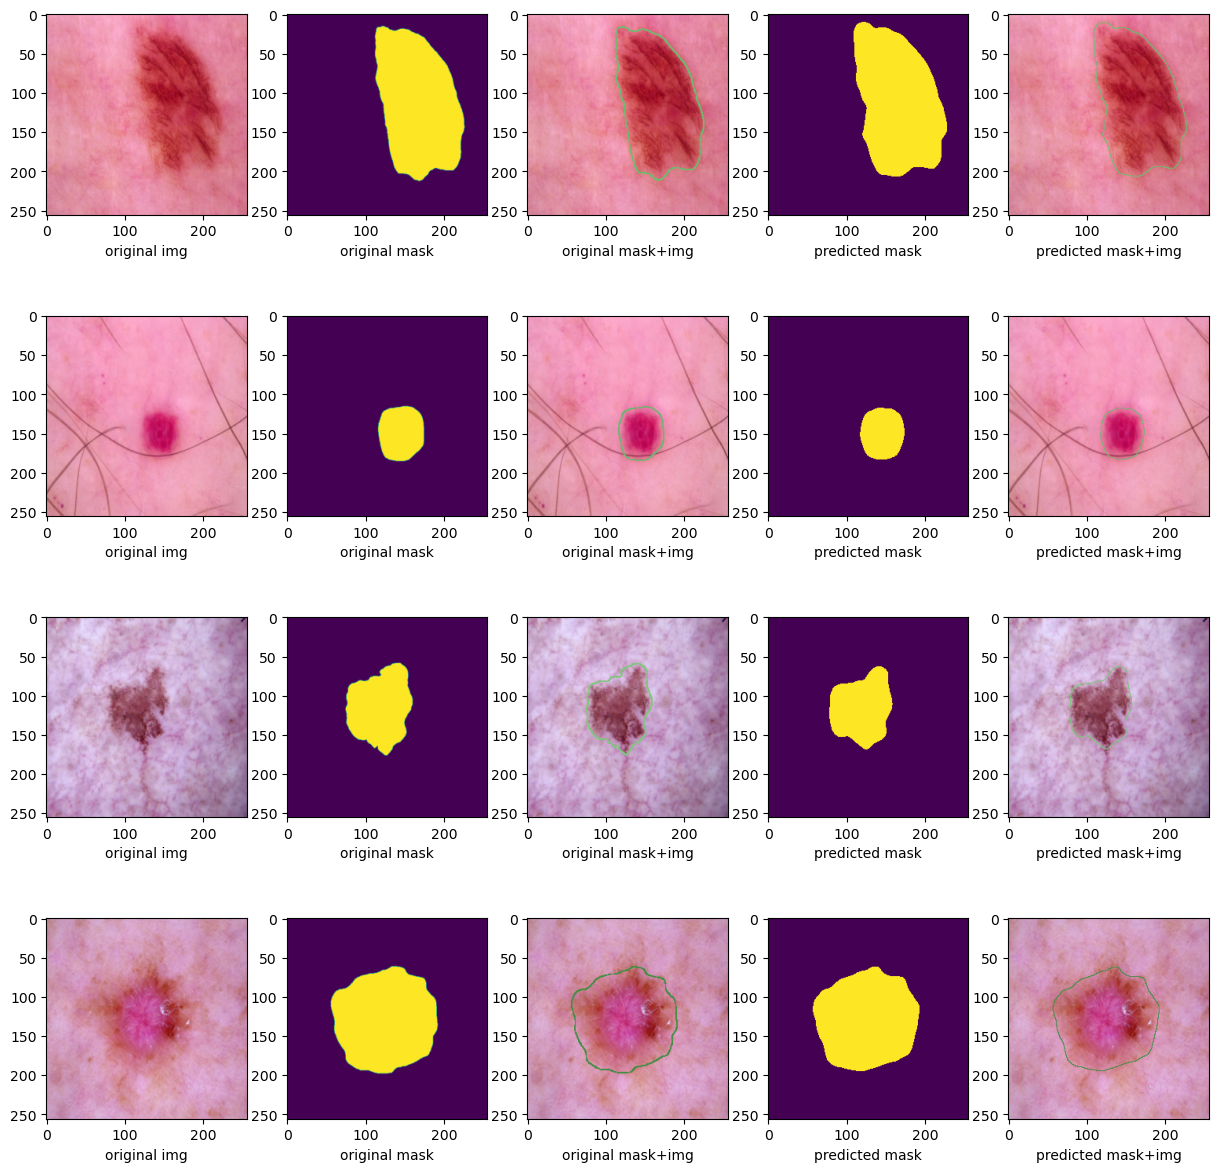

In [59]:
total_loss_test, total_iou_test, total_dice_test = segmentation_eval(val_loader, full_model_unet, criterion, optimizer, 0.5, show=True, validation=False, epoch=None)

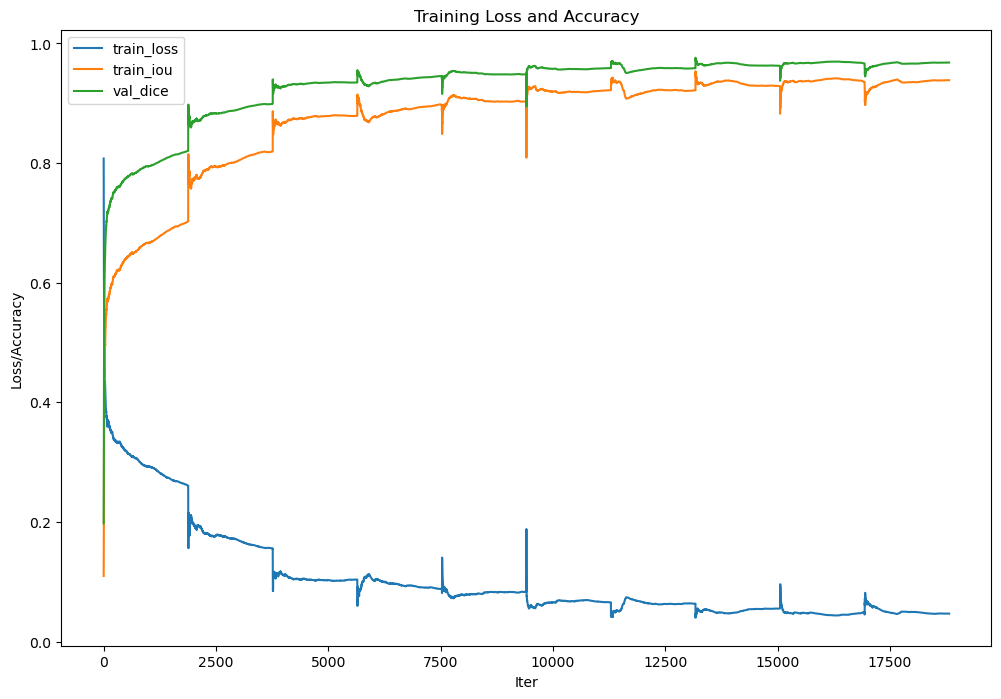

In [49]:
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_iou_train, label="train_iou")
plt.plot(total_dice_train, label="val_dice")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iter")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

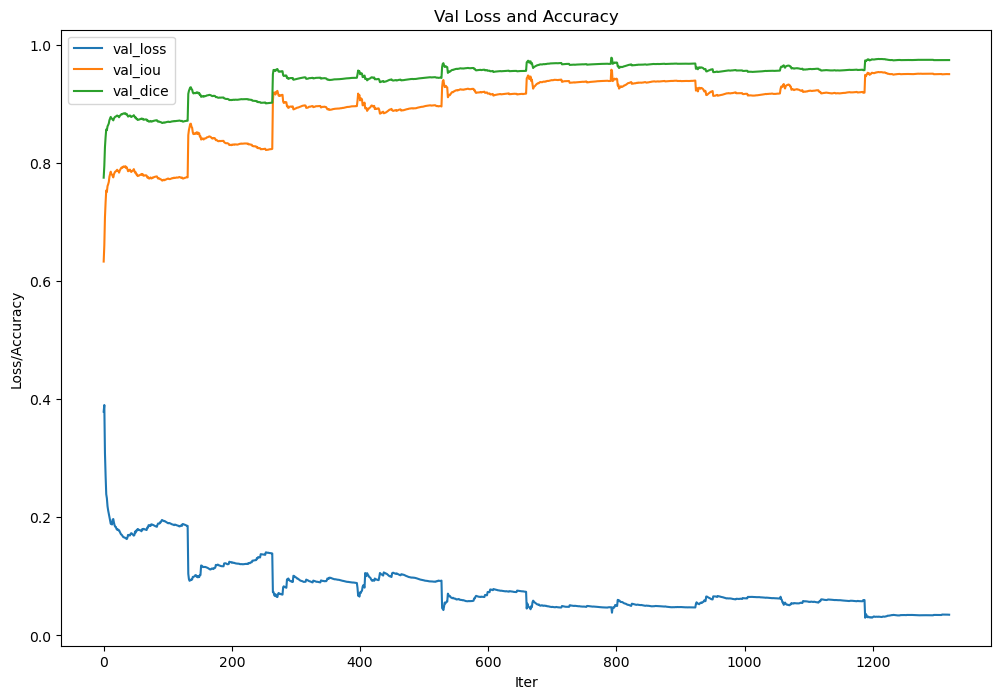

In [50]:
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_iou_val, label="val_iou")
plt.plot(total_dice_val, label="val_dice")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iter")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()